In [ ]:
from matplotlib import path as mpath

class OwnErrorMarker(mpath.Path):

    def __init__(self, *args, subtract_mean=True, **kwargs):
        super().__init__(*args, **kwargs)

        if subtract_mean:
            self.vertices = (self.vertices - self.vertices.mean(axis=0))
        self._vertices_orig = self.vertices
        self._scatter_kwargs = dict(facecolors='none',
                                    capstyle='round')

    def reset(self):
        self.vertices = self._vertices_orig

    def top(self, scale=1):
        self.vertices = self._vertices_orig * [scale, scale]
        return self

    def bot(self, scale=1):
        self.vertices = self._vertices_orig * [scale, -scale]
        return self

    def update_scatter_kwargs(self, **scatter_kwargs):
        self._scatter_kwargs.update(**scatter_kwargs)

    def get_scatter_kwargs(self):
        return self._scatter_kwargs

    def add_to_legend(self, ax, label, offset=3, ms=100,
                      rotate=True, scale=1, color='k',
                      do_not_use_label=False):
        loc_vertices = np.concatenate(
            [(self._vertices_orig + [0, offset]) * [scale, scale],
             (self._vertices_orig + [0, offset]) * [scale, -scale]])

        loc_codes = np.concatenate([self.codes, self.codes])

        if rotate:
            loc_vertices = loc_vertices @ [[0, 1], [1, 0]]

        return ax.scatter(np.nan, np.nan, s=ms, edgecolor=color,
                          marker=mpath.Path(loc_vertices, loc_codes),
                          label=None if do_not_use_label else label,
                          **self._scatter_kwargs)


ERROR_MARKERS = {
    "fancy": OwnErrorMarker(
        [[-2, -1], [-1, 1], [1, 1], [2, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO, mpath.Path.LINETO]),
    "rectangle": OwnErrorMarker(
        [[-3, -1], [-3, 1], [3, 1], [3, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO, mpath.Path.LINETO]),
    "triangle": OwnErrorMarker(
        [[-2, -1], [0, 1], [2, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO]),
}

# plotting stuff
def plot_error_markers(ax, x, y, ydown, yup=None, markerstyle='rectangle',
                       scale=1, color='k', **scatter_kwargs):
    #from kapu.extension.markers import ERROR_MARKERS

    om = ERROR_MARKERS[markerstyle]

    scatter_kwargs.update(**om.get_scatter_kwargs())

    if yup is None:
        yup = ydown

    sca1 = ax.scatter(x, y + yup, edgecolors=color,
                      marker=om.top(scale), **scatter_kwargs)
    sca2 = ax.scatter(x, y - ydown, edgecolors=color,
                      marker=om.bot(scale), **scatter_kwargs)

    return (sca1, sca2), om

# legend stuff
def add_errormarker_labels(ax, markers, labels, colors=None,
                           new_legend=False, rotate=True, legend_kwargs={}):

    if colors is None:
        colors = ['k'] * len(markers)

    pcs = []
    for marker, label, color in zip(markers, labels, colors):
        marker = ERROR_MARKERS[marker]
        path_collection = marker.add_to_legend(ax, label, rotate=rotate, color=color,
do_not_use_label=new_legend)
        pcs.append(path_collection)

    if new_legend:
        legend = ax.legend(pcs, labels, **legend_kwargs)
        return legend
    else:
        pass

In [ ]:
from utils.binaries import *
from utils.plotting import *

fig, ax = plt.subplots()

dy = np.abs(np.random.normal(scale=5, size=50))
x = np.linspace(0, 10, 50)
y = x + dy

ax.errorbar(x, y, 0.5*dy, fmt='o', label='hallo')
plot_error_markers(ax, x, y, dy, s=20)


ax.legend()

In [ ]:
from utils.auger.sd import sim

In [ ]:
test_sim = sim.Simulation('icrc2025-test7-SdMdInfillSimRec',
                        offline='icrc2025-test7',
                        src='/cr/users/filip/Projects/PhotonSimulations/discrimination/icrc2025-test5-SdMdInfillSimRec',
                        request_memory = "6G",
                        primary="proton",
                        energy="18_18.5",
                        model="epos_lhc",
                        seed = 5,
                        queue = 5000,
                        verbose=False)

In [ ]:
is_sim_file = (lambda s: s.startswith("DAT")
                           and not s.endswith(".long")
                           and not s.endswith(".lst")
                           and not s.endswith(".gz"))

target_path = '/lsdf/auger/corsika/prague/EPOS_LHC/photon/16_16.5'
print(len(list(filter(is_sim_file, os.listdir(target_path)))))

In [ ]:
from utils.binaries import *
from utils.plotting import *
from utils.auger.fd.NightSkyBackground import *

In [ ]:
test = CameraNSB("LosMorados", 3)

In [ ]:
pixel_210 = test.get_pixel(210)
pixel_210.show(show_jumps=True)

In [ ]:
pixel_210.get_model(show=True, n_peaks=1, height=8)

In [ ]:


def add_cloud_information(self):

    m = {
        "LosLeones" : 0,
        "LosMorados" : 6,
        "LomaAmarilla" : 12,
        "Coihueco" : 18,
        "Heat" : 24
    }[self.site] + self.tel

    clouds_db = "/cr/tempdata01/filip/clouds_2010_2024/"
    times, mask = np.loadtxt(f"{clouds_db}/clouds_combined_m{m}.txt", 
                             dtype=int, usecols=[0, self.pixel], unpack=True)
    
    gps_to_datetime = lambda t: datetime.fromtimestamp(t + GPS_OFFSET)
    self.df['cloud_time_diff'] = np.nan
    self.df['clouds'] = 1
    for i in range(len(times)):

        time = gps_to_datetime(times[i])
        closest_df_row = np.argmin(np.abs(self.df['datetime'] - time))
        cloud_time_diff = np.abs((self.df.iloc[closest_df_row, 1] - time).total_seconds())

        if cloud_time_diff > 3600: continue

        self.df.iloc[closest_df_row, -2] = cloud_time_diff
        self.df.iloc[closest_df_row, -1] = mask[i]

In [ ]:
pixel_210.df

In [ ]:
add_cloud_information(pixel_210)

In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.auger.sd import discrimination

17:49:00 (   +1.2s) [INFO   ] -- import logging
17:49:00 (  +180ms) [INFO   ] -- import numpy as np
17:49:00 (   +10ms) [INFO   ] -- import uncertainties
17:49:01 (  +702ms) [INFO   ] -- import pandas as pd
17:49:01 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
17:49:01 (    +3ms) [INFO   ] -- import binaries.tools as tools
17:49:01 (    +3ms) [INFO   ] -- set MONI_PATH = PosixPath('/cr/work/filip/monit_and_sd')
17:49:01 (    +1ms) [INFO   ] -- set HIST_PATH = PosixPath('/cr/work/filip/monit_and_sd')
17:49:01 (    +0ms) [INFO   ] -- set PLOT_PATH = PosixPath('/cr/data01/filip/plots')
17:49:01 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/cr/data01/filip/Data')
17:49:01 (    +1ms) [INFO   ] -- set SCAN_PATH = PosixPath('/cr/data01/filip/xy-calibration')
17:49:01 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/cr/data01/filip/offline/install')
17:49:02 (  +706ms) [INFO   ] -- import matplotlib.pyplot as plt
17:49:03 (   +1.1s) [INFO   ] -- import seaborn a

In [2]:
path = "/cr/tempdata01/filip/json_data/icrc2025-test7/"

data = {
    'protons': tools.pickle_load(f"{path}/proton_new.pkl"),
    'photons': tools.pickle_load(f"{path}/photon_new.pkl"),
}

In [3]:
def score_mb(df):

    def rho_pr(energy, zenith):

        lg10_rho_0 = np.poly1d([-0.591, 0.262, -0.108])
        x = lambda t: np.cos(t)**2 - np.cos(30 * np.pi/180)**2
        c = 0.890

        return 10**lg10_rho_0(x(zenith)) * (np.log10(energy)/17)**c

    score = np.zeros(len(df)) + np.nan
    for _, shower in df.groupby("shower_index"):

        energy = shower["energy"].unique()[0]
        zenith = shower["zenith"].unique()[0]
        rho_pr_this_shower = rho_pr(energy, zenith)

        mu_frac = shower["muon_density"] / rho_pr_this_shower
        dist_frac = shower["spd"] / 200

        score[shower.index] = np.log10((mu_frac * dist_frac).sum())

    return score

In [4]:
data = discrimination.add_score(data, score_mb, "m_b")

In [1]:
def get_templates(data, energy_bins, zenith_bins, score, n_bins=100, show=True):

    if show:
        fig1, axes1 = plt.subplots(len(energy_bins)-1, len(zenith_bins)-1, sharex=True, sharey=True)      # for templates
        plt.subplots_adjust(hspace=0.04, wspace=0.02)
        fig2, axes2 = plt.subplots(len(energy_bins)-1, len(zenith_bins)-1, sharex=True, sharey=True)      # for performance
        plt.subplots_adjust(hspace=0.04, wspace=0.02)

    vmin = np.min([data["protons"][score].min(), data["photons"][score].min()])
    vmax = np.max([data["protons"][score].max(), data["photons"][score].max()])
    templates = {}

    for row, (e_low, e_high) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
        energy_key = f"{np.log10(e_low):.1f}_{np.log10(e_high):.1f}"
        templates[energy_key] = {}

        for col, (t_low, t_high) in enumerate(zip(zenith_bins[:-1], zenith_bins[1:])):
            
            select = lambda df: df[(df["energy"].between(e_low, e_high))
                                   & df["zenith"].between(t_low, t_high)]

            df_protons = select(data["protons"])[score].unique()
            df_photons = select(data["photons"])[score].unique()

            if show:
                if len(zenith_bins) > 2:
                    template_ax, performance_ax = axes1[row, col], axes2[row, col]
                else:
                    template_ax, performance_ax = axes1[row], axes2[row]

                ylabel = f"${np.log10(e_low):.1f} \leq \mathrm{{log}}_{{10}}(E\,/\,\mathrm{{eV}}) \leq {np.log10(e_high):.1f}$"
                xlabel = fr"${t_low * 180/np.pi:.0f}^\circ\,\leq\,\theta\,\leq\,{t_high * 180/np.pi:.0f}^\circ$"
            
                if not col:
                    template_ax.set_yscale("log")
                    template_ax.set_yticks([])
                    performance_ax.set_yticks([])

                n_phot, bins, _ = template_ax.hist(df_photons, range=(vmin, vmax), bins=n_bins, histtype='step',
                                                label=rf"$\gamma$ ({len(df_photons)} evts)", density=True)
                n_prot, bins, _ = template_ax.hist(df_protons, range=(vmin, vmax), bins=n_bins, histtype='step',
                                                label=rf"$p$ ({len(df_protons)} evts)", density=True)

                template_ax.legend(ncol=2, fontsize=6, title=f"{ylabel}, {xlabel}", title_fontsize=5)

                signal_efficiency = np.cumsum(n_phot) / np.sum(n_phot)
                bkg_contamination = (np.cumsum(n_prot) / np.sum(n_prot)) / (np.cumsum(n_prot + n_phot) / np.sum(n_prot + n_phot))

                performance_ax.scatter(signal_efficiency, bkg_contamination)
                performance_ax.set_yscale("log")
            
            else:
                n_phot, bins = np.histogram(df_photons, range=(vmin, vmax), bins=n_bins, density=True)
                n_prot, bins = np.histogram(df_protons, range=(vmin, vmax), bins=n_bins, density=True)

            zenith_key = f"{t_low * 180/np.pi:.0f}_{t_high * 180/np.pi:.0f}"
            templates[energy_key][zenith_key] = {
                "proton": n_prot,
                "photon": n_phot
            }

    templates["bins"] = bins
    return templates

/tmp/ipykernel_3253675/4254756393.py:47: RuntimeWarning: invalid value encountered in divide
  bkg_contamination = (np.cumsum(n_prot) / np.sum(n_prot)) / (np.cumsum(n_prot + n_phot) / np.sum(n_prot + n_phot))


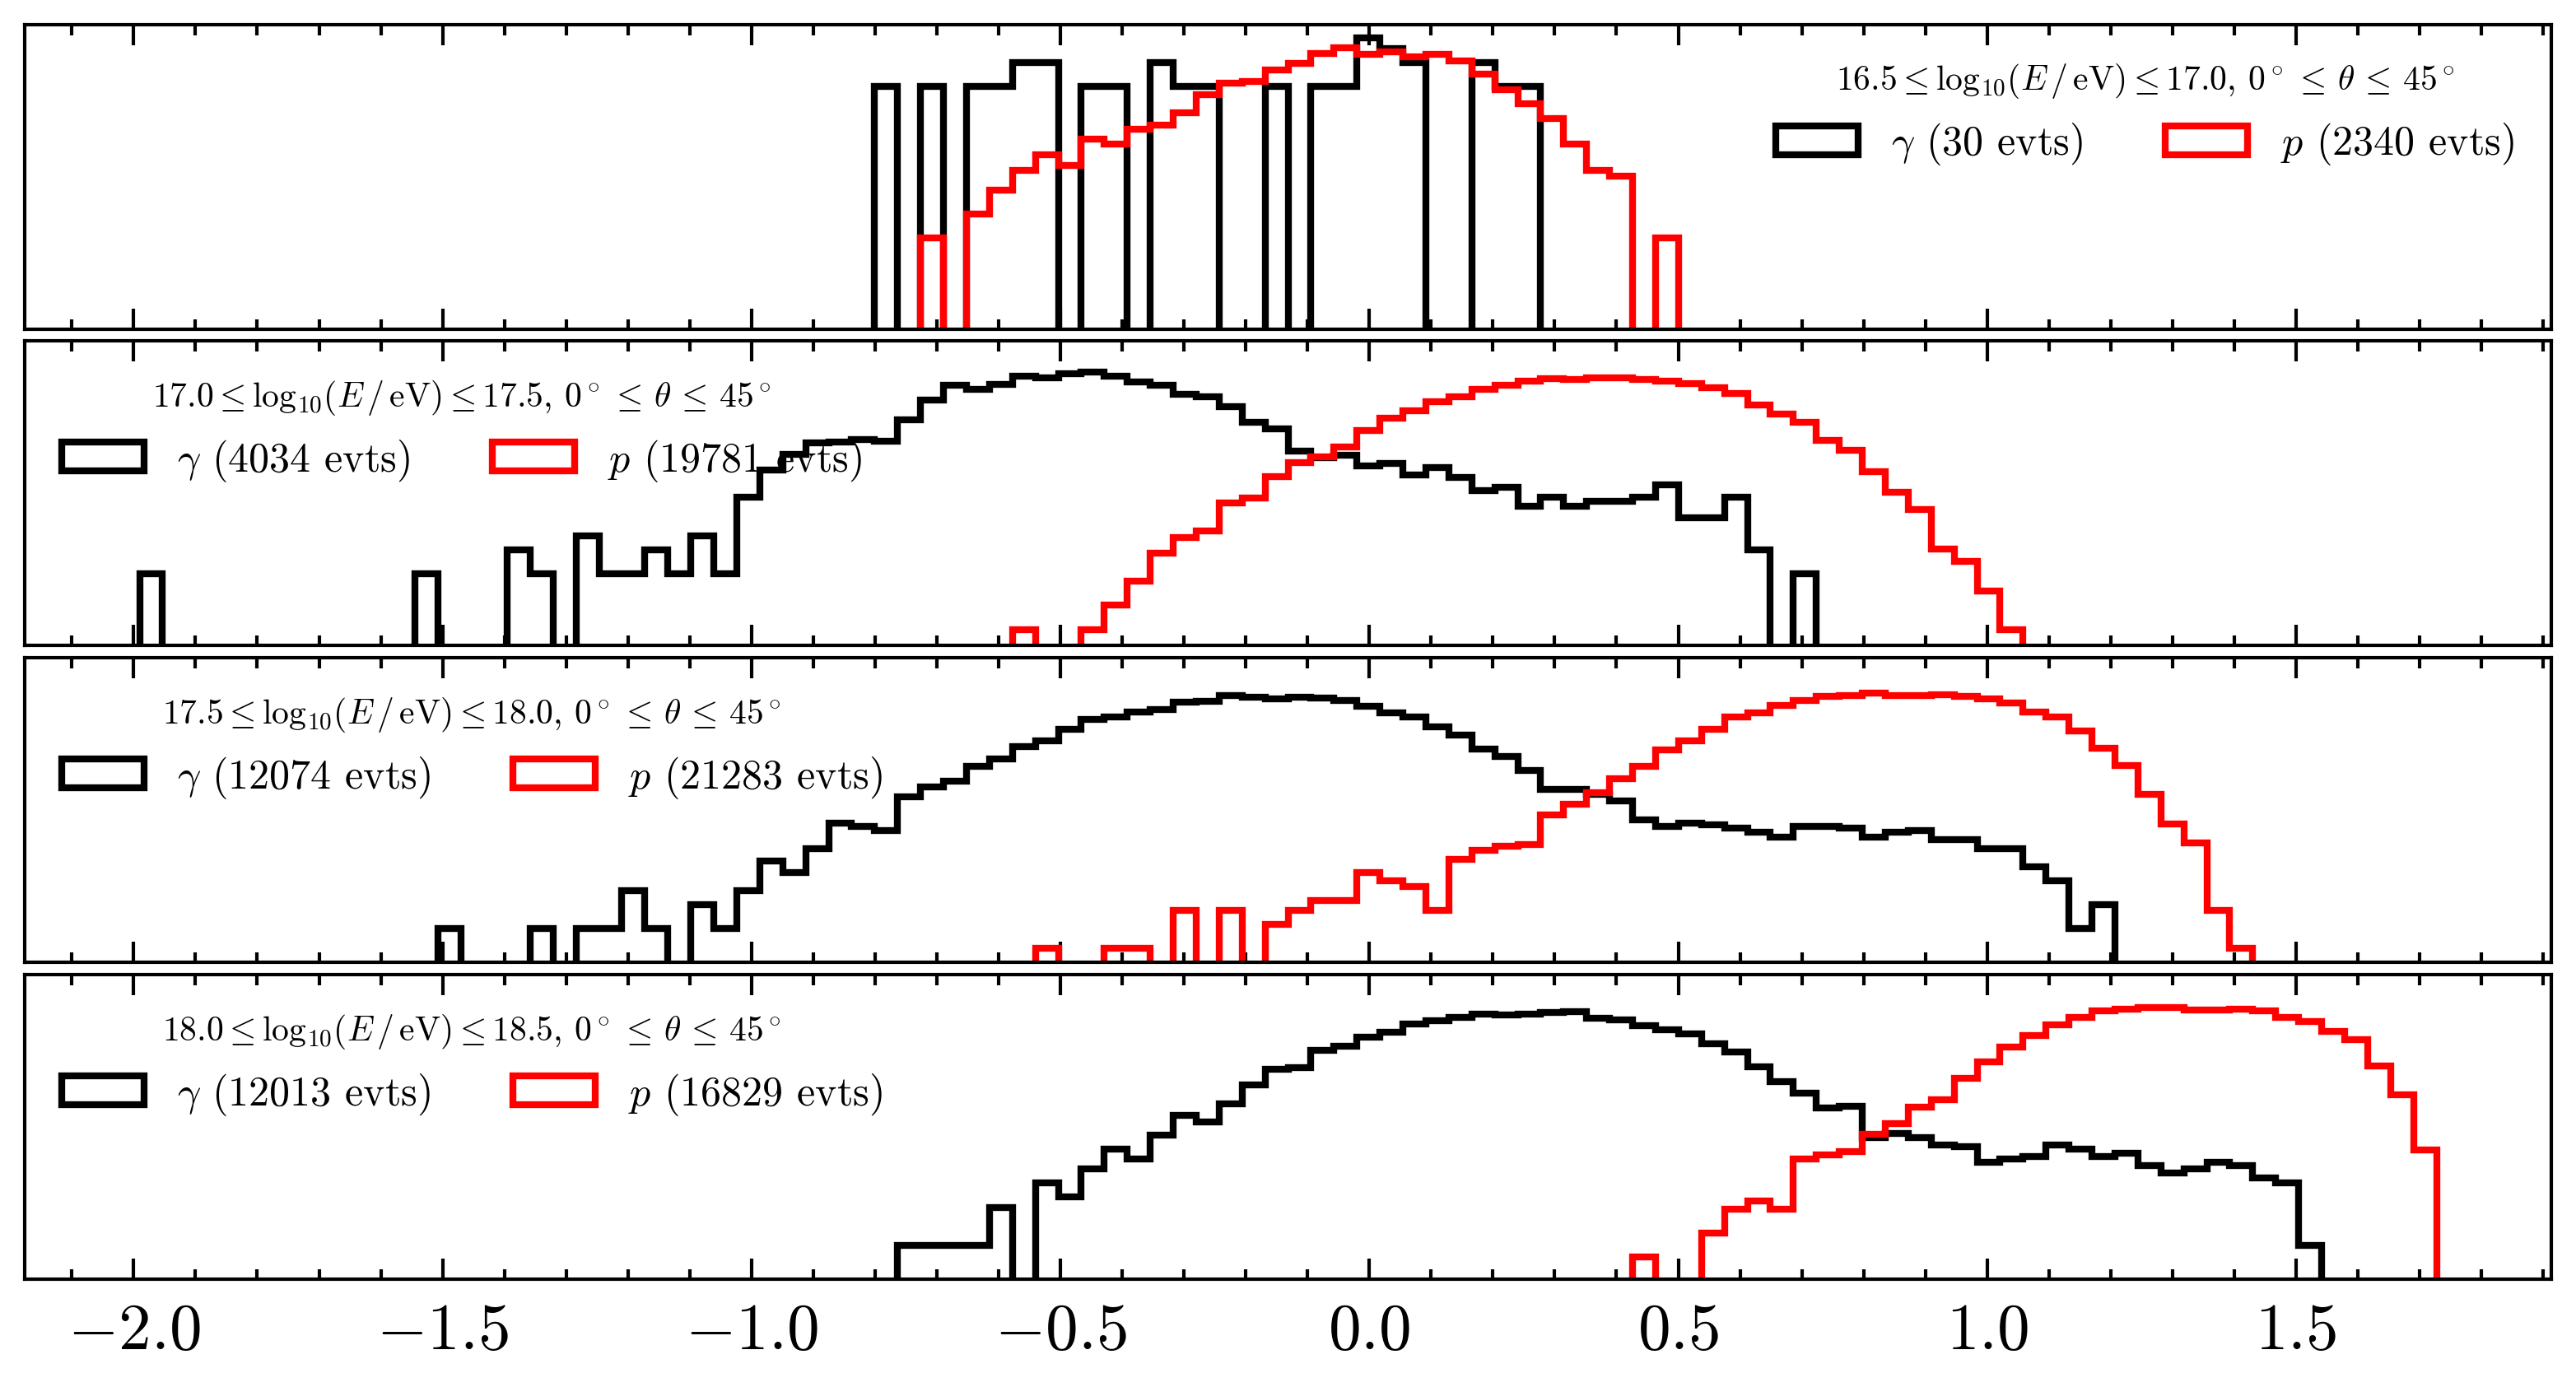

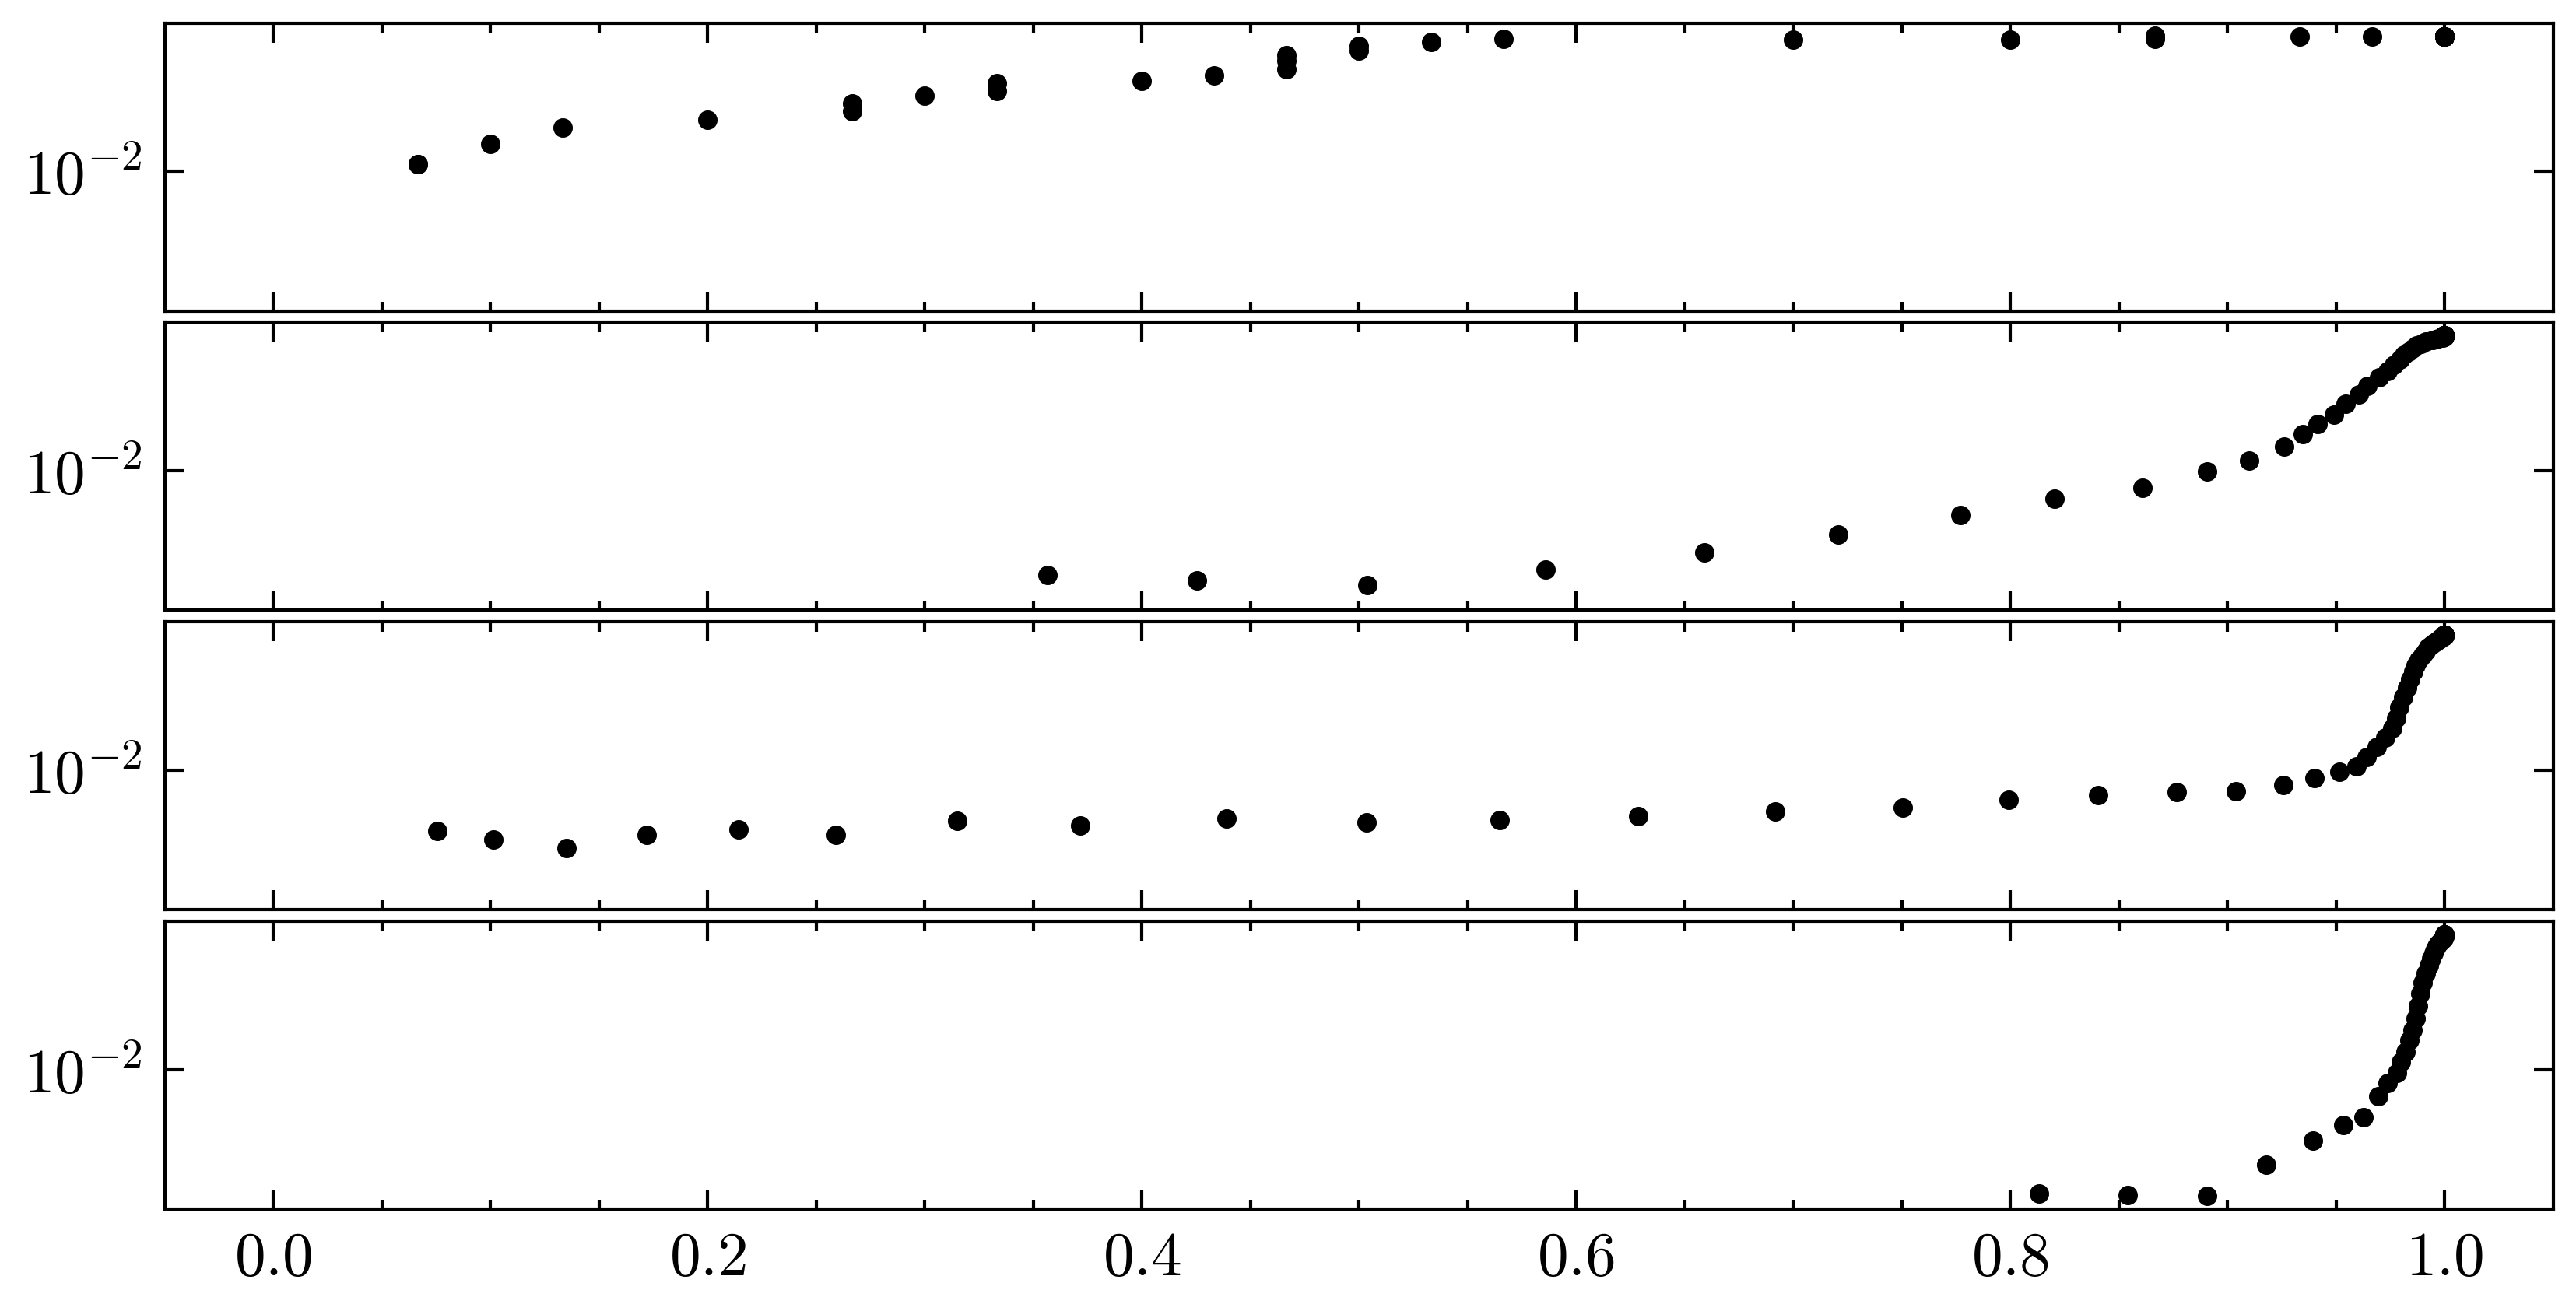

In [50]:
test = get_templates(data, 10**np.arange(16.5, 18.6, 0.5), np.linspace(0, np.pi/4, 2), "m_b")